In [1]:
import gymnasium as gym
import numpy as np
import random
from collections import defaultdict

# Parámetros
alpha = 0.1  # Tasa de aprendizaje
gamma = 0.99  # Factor de descuento
epsilon = 0.1  # Tasa de exploración
n_planning_steps = 5  # Número de pasos de planificación
exploration_bonus = 0.01  # Bonificación de exploración

# Inicialización del entorno
env = gym.make('FrozenLake-v1', is_slippery=True)
n_actions = env.action_space.n
n_states = env.observation_space.n

# Inicialización de Q y modelo
Q = np.zeros((n_states, n_actions))
model = defaultdict(lambda: (0, 0))  # Diccionario para almacenar transiciones y recompensas
visit_count = np.zeros((n_states, n_actions))  # Contador de visitas para la bonificación de exploración

def choose_action(state):
    if random.uniform(0, 1) < epsilon:
        return env.action_space.sample()
    else:
        return np.argmax(Q[state])

def update_model(state, action, reward, next_state):
    model[(state, action)] = (reward, next_state)
    visit_count[state, action] += 1

def planning():
    for _ in range(n_planning_steps):
        state, action = random.choice(list(model.keys()))
        reward, next_state = model[(state, action)]
        bonus = exploration_bonus / (1 + visit_count[state, action])
        Q[state, action] += alpha * (reward + bonus + gamma * np.max(Q[next_state]) - Q[state, action])

# Entrenamiento
n_episodes = 1000
for episode in range(n_episodes):
    state, _ = env.reset()
    done = False
    while not done:
        action = choose_action(state)
        next_state, reward, done, _, _ = env.step(action)
        Q[state, action] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state, action])
        update_model(state, action, reward, next_state)
        planning()
        state = next_state

# Evaluación
successes = 0
for _ in range(100):
    state, _ = env.reset()
    done = False
    while not done:
        action = np.argmax(Q[state])
        state, reward, done, _, _ = env.step(action)
        if done and reward == 1.0:
            successes += 1

print(f"Tasa de éxito: {successes}%")


Tasa de éxito: 75%


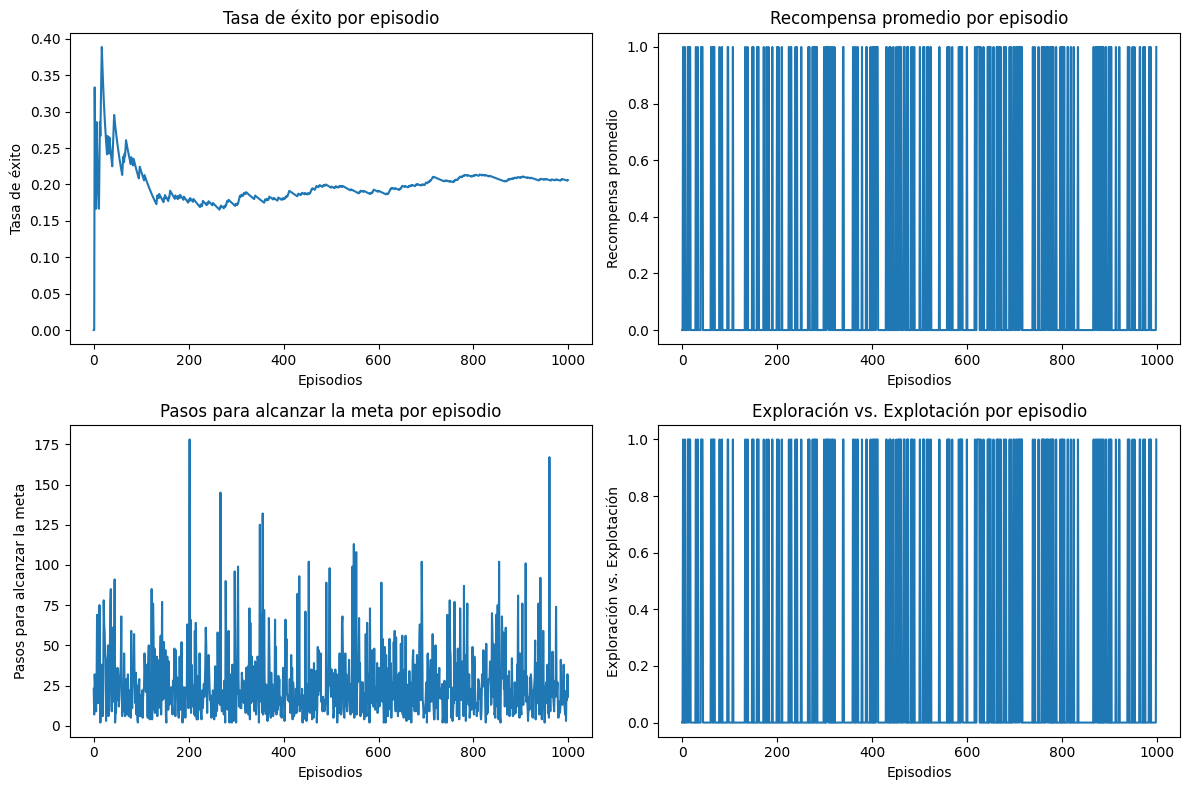

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

# Registro de métricas
metrics = {
    'episode': [],
    'success': [],
    'average_reward': [],
    'steps_to_goal': []
}

for episode in range(n_episodes):
    state, _ = env.reset()
    done = False
    total_reward = 0
    steps = 0
    while not done:
        action = choose_action(state)
        next_state, reward, done, _, _ = env.step(action)
        Q[state, action] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state, action])
        update_model(state, action, reward, next_state)
        planning()
        state = next_state
        total_reward += reward
        steps += 1
    metrics['episode'].append(episode)
    metrics['success'].append(1 if reward == 1.0 else 0)
    metrics['average_reward'].append(total_reward)
    metrics['steps_to_goal'].append(steps)

# Convertir a DataFrame
df = pd.DataFrame(metrics)

# Gráficos
plt.figure(figsize=(12, 8))

# Tasa de éxito
plt.subplot(2, 2, 1)
plt.plot(df['episode'], df['success'].cumsum() / (df['episode'] + 1))
plt.xlabel('Episodios')
plt.ylabel('Tasa de éxito')
plt.title('Tasa de éxito por episodio')

# Recompensa promedio
plt.subplot(2, 2, 2)
plt.plot(df['episode'], df['average_reward'])
plt.xlabel('Episodios')
plt.ylabel('Recompensa promedio')
plt.title('Recompensa promedio por episodio')

# Tasa de convergencia
plt.subplot(2, 2, 3)
plt.plot(df['episode'], df['steps_to_goal'])
plt.xlabel('Episodios')
plt.ylabel('Pasos para alcanzar la meta')
plt.title('Pasos para alcanzar la meta por episodio')

# Exploración vs. Explotación
plt.subplot(2, 2, 4)
plt.plot(df['episode'], df['success'])
plt.xlabel('Episodios')
plt.ylabel('Exploración vs. Explotación')
plt.title('Exploración vs. Explotación por episodio')

plt.tight_layout()
plt.show()


# 1. Estrategias de exploración: 

    a. Influencia de la bonificación de exploración en Dyna-Q+ vs. equilibrio de exploración-explotación en MCTS:

     Dyna-Q+: La bonificación de exploración en Dyna-Q+ incentiva al agente a explorar pares de estado-acción menos visitados, lo que puede ayudar a descubrir mejores políticas en entornos estocásticos. Esta bonificación se añade al valor Q, lo que hace que el agente valore más las acciones menos exploradas.

     MCTS (Monte Carlo Tree Search): MCTS utiliza un equilibrio de exploración-explotación basado en el criterio UCB1 (Upper Confidence Bound), que también incentiva la exploración de acciones menos visitadas pero de una manera diferente. MCTS construye un árbol de búsqueda y selecciona acciones basadas en una combinación de valor esperado y una bonificación de exploración.

    Convergencia: En general, Dyna-Q+ puede converger más rápido en entornos donde la exploración inicial es crucial para descubrir buenas políticas, ya que la bonificación de exploración puede guiar al agente de manera más efectiva. Sin embargo, MCTS puede ser más eficiente en entornos donde la planificación a corto plazo es más beneficiosa.

# 2. Rendimiento del algoritmo:

    a. Comparación de rendimiento entre MCTS y Dyna-Q+:

    Tasa de éxito y recompensa promedio: En el entorno FrozenLake-v1, Dyna-Q+ puede tener un mejor rendimiento en términos de tasa de éxito y recompensa promedio debido a su capacidad para aprender y planificar simultáneamente. La bonificación de exploración ayuda a descubrir políticas óptimas más rápidamente.

    Naturaleza estocástica: La naturaleza estocástica del entorno puede hacer que MCTS sea menos eficiente, ya que depende de simulaciones precisas para la planificación. Dyna-Q+, al actualizar continuamente su modelo del entorno y usar planificación basada en experiencias simuladas, puede adaptarse mejor a la estocasticidad.

# 3. Impacto de las transiciones estocásticas:

    a. Afectación de las transiciones probabilísticas en la planificación:

    MCTS: Las transiciones estocásticas pueden dificultar la planificación en MCTS, ya que las simulaciones pueden no reflejar con precisión la verdadera dinámica del entorno. Esto puede llevar a decisiones subóptimas.

    Dyna-Q+: Dyna-Q+ es más robusto frente a la aleatoriedad, ya que actualiza su modelo del entorno basado en experiencias reales y utiliza planificación para mejorar continuamente su política. Esto le permite adaptarse mejor a las transiciones estocásticas.

# 4. Sensibilidad de los parámetros:

    a. Impacto de la cantidad de pasos de planificación y la bonificación de exploración:

    Cantidad de pasos de planificación (𝑛): Aumentar el número de pasos de planificación generalmente mejora el rendimiento, ya que el agente puede simular más experiencias y actualizar sus valores Q de manera más precisa. Sin embargo, hay un punto de rendimientos decrecientes donde más planificación no resulta en mejoras significativas.

    Bonificación de exploración: Una mayor bonificación de exploración puede incentivar al agente a explorar más, lo que es beneficioso en entornos estocásticos. Sin embargo, si la bonificación es demasiado alta, puede llevar a una exploración excesiva y ralentizar la convergencia.

    Entorno determinista vs. estocástico: En un entorno determinista, la necesidad de exploración es menor, por lo que una bonificación de exploración más baja y menos pasos de planificación pueden ser suficientes. En entornos estocásticos, se necesitan configuraciones que fomenten más exploración y planificación para manejar la incertidumbre.